In [152]:
import numpy as np

from engine import RMG, AdvRw
from agent import RandomAgent, IndQLearningAgent, FPLearningAgent, FPQwForgetAgent, Level2QAgent, Level2QAgent_fixed

In [153]:
A = np.array([[[1,2],[3,4]]])


print(A[0,:,:])
print(A.shape)
print(np.dot(A[0,:,:], np.array([0.3,0.7])))

print(np.tensordot(A, np.array([0.3,0.7]), axes=([1],[0])))

[[1 2]
 [3 4]]
(1, 2, 2)
[1.7 3.7]
[[2.4 3.4]]


In [154]:
possible_actions = [0, 1]  # Target A or B
gamma = 0.8


rw_agents = []
agents = [IndQLearningAgent, FPQwForgetAgent, Level2QAgent, Level2QAgent_fixed]


for agent in agents:
    
    print('Beginning experiments with agent ', agent.__name__)

    N_EXP = 20

    r0ss = []

    smooth = 100

    for n in range(N_EXP):
        batch_size = 1
        max_steps = 1

        mode = 'adversary'
        env = AdvRw(mode, p=0.6)  # p is only used in neutral mode
        env.reset()

        p = agent(possible_actions, enemy_action_space=possible_actions, n_states=1, learning_rate=0.1, epsilon=0.1, gamma=gamma)

        # Stateless interactions (agents do not have memory)
        s = 0

        n_iter = 100000 + smooth # because of the smoothening in the graphics

        r0s = []
        r1s = []

        for i in range(n_iter):

            # A full episode:
            done = False

            while not done:

                # Agents decide
                a0 = p.act(obs=s)

                # World changes
                _, (r0, _), done, _ = env.step(a0)

                # Agents learn
                if r0 > 0: # p was correct
                    a1 = a0
                else:
                    a1 = 1 - a0
    
                #r1 = -r0
                r1 = float(r0 < 0) 
                #r1 = float(r0 < 0) - 1
                #r1 = float(r0 < 0)*0.05
                #r1 = float(r0 < 0)*2 - 1
                p.update(s, (a0, a1), (r0, r1) , s )

                #s = new_s  #stateless!

                r0s.append(r0)

            env.reset()

        r0ss.append(r0s)
        
    rw_agents.append(r0ss)

Beginning experiments with agent  IndQLearningAgent
Beginning experiments with agent  FPQwForgetAgent
Beginning experiments with agent  Level2QAgent
Beginning experiments with agent  Level2QAgent_fixed


In [155]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

We report moving avearage of rewards, since it's common in RL taks

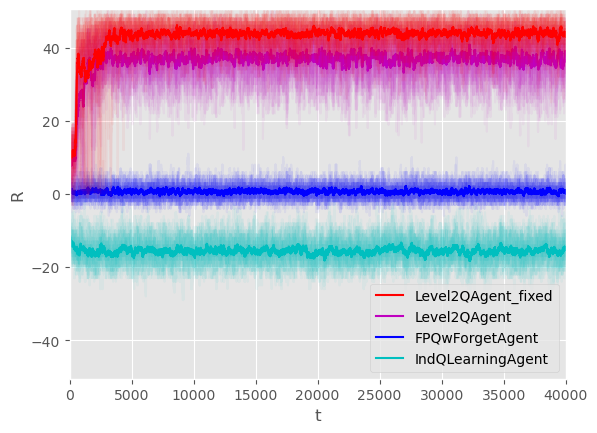

In [156]:
%matplotlib inline
import matplotlib.pyplot as plt

# We set a fancy theme
plt.style.use('ggplot')

colors = 'cbmr'
plt.axis([0, max_steps*n_iter - smooth, -50.5, 50.5])
for j,a in enumerate(agents):
    r0ss = rw_agents[j]
    for i in range(N_EXP):
        plt.plot(moving_average(r0ss[i], 100), colors[j], alpha=0.05)

    plt.plot(moving_average(np.asarray(r0ss).mean(axis=0), 100), colors[j], alpha=1)

plt.xlabel('t')
plt.ylabel('R')

from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
custom_lines = [Line2D([0], [0], color=colors[::-1][i]) for i,_ in enumerate(agents)]

plt.legend(custom_lines,[a.__name__ for a in reversed(agents)], loc=4)

plt.savefig('img/4C_08_binary' + mode + '.png')

For the adversary case (no forget):

In [170]:
def calculate_DM_statistics(rw_agents, agent_index):
    # Convert the selected agent's rewards to a NumPy array
    rewards = np.asarray(rw_agents[agent_index])
    
    # Calculate cumulative sum along axis 1
    cumulative_rewards = rewards.cumsum(axis=1)
    
    # Mean of cumulative rewards for all steps, across all experiments
    mean_cumulative_rewards_all_steps = cumulative_rewards.mean(axis=0).mean()
    formatted_mean_cumulative_rewards_all_steps = f"{mean_cumulative_rewards_all_steps:,.2f}".replace(",", " ")
    
    # Mean of cumulative rewards for last step, across all experiments
    mean_cumulative_rewards_last_step = cumulative_rewards[:,-1].mean()
    formatted_mean_cumulative_rewards_last_step = f"{mean_cumulative_rewards_last_step:,.2f}".replace(",", " ")
    
    # Mean variance of cumulative rewards for all steps, across all experiments
    mean_variance_all_steps = cumulative_rewards.var(axis=0).mean()
    formatted_mean_variance_all_steps = f"{mean_variance_all_steps:,.2f}".replace(",", " ")
    
    # Mean variance of cumulative rewards only last step, across all experiments
    mean_variance_last_step = cumulative_rewards[:, -1].var(axis=0)
    formatted_mean_variance_last_step = f"{mean_variance_last_step:,.2f}".replace(",", " ")
    
    # Cumulative rewards at the last step
    cumulative_rewards_last_step = cumulative_rewards[:, -1]
    
    # Mean of rewards for all steps, across all experiments
    mean_rewards_all_steps = rewards.mean(axis=0).mean()
    formatted_mean_rewards_all_steps = f"{mean_rewards_all_steps:,.2f}".replace(",", " ")
    
    # Mean variance of rewards for all steps, across all experiments
    mean_variance_rewards_all_steps = rewards.var(axis=0).mean()
    formatted_mean_variance_rewards_all_steps = f"{mean_variance_rewards_all_steps:,.2f}".replace(",", " ")
    
    return {
        "mean_cumulative_rewards_all_steps": formatted_mean_cumulative_rewards_all_steps,
        "mean_cumulative_rewards_last_step": formatted_mean_cumulative_rewards_last_step,
        "mean_variance_all_steps": formatted_mean_variance_all_steps,
        "mean_variance_last_step": formatted_mean_variance_last_step,
        "cumulative_rewards_last_step": cumulative_rewards_last_step,
        "mean_rewards_all_steps": formatted_mean_rewards_all_steps,
        "mean_variance_rewards_all_steps": formatted_mean_variance_rewards_all_steps
    }
    

In [171]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-1)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])


Mean cumulative reward for all steps: 839 860.73
Mean cumulative reward for last step: 1 717 770.00
Mean variance of cumulative rewards for all steps: 56 510 721.59
Mean variance of cumulative rewards only last step: 84 139 100.00
Cumulative rewards at the last step: [1720600 1708700 1724800 1711400 1701100 1722700 1715200 1705800 1737600
 1725300 1714300 1725100 1713500 1735300 1725100 1719300 1717100 1712600
 1711300 1708600]
Mean rewards for all steps: 42.84
Mean variance of rewards for all steps: 610.57


In [172]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-2)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: 714 969.06
Mean cumulative reward for last step: 1 456 860.00
Mean variance of cumulative rewards for all steps: 52 827 464.65
Mean variance of cumulative rewards only last step: 71 793 400.00
Cumulative rewards at the last step: [1460700 1466000 1441900 1470900 1451000 1452100 1456700 1462300 1462500
 1450500 1451900 1469900 1444500 1462000 1452600 1455500 1442800 1461700
 1468300 1453400]
Mean rewards for all steps: 36.33
Mean variance of rewards for all steps: 1 104.90


In [173]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-3)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: 12 820.84
Mean cumulative reward for last step: 25 335.00
Mean variance of cumulative rewards for all steps: 3 725 921.49
Mean variance of cumulative rewards only last step: 8 168 275.00
Cumulative rewards at the last step: [25600 25900 28400 23300 25800 25400 25100 26300 22200 22200 26800 25800
 26400 23900 26300 32500 30100 21100 23400 20200]
Mean rewards for all steps: 0.63
Mean variance of rewards for all steps: 2 373.92


In [174]:
statistics = calculate_DM_statistics(rw_agents,agent_index=-4)

print("Mean cumulative reward for all steps:", statistics["mean_cumulative_rewards_all_steps"])
print("Mean cumulative reward for last step:", statistics["mean_cumulative_rewards_last_step"])
print("Mean variance of cumulative rewards for all steps:", statistics["mean_variance_all_steps"])
print("Mean variance of cumulative rewards only last step:", statistics["mean_variance_last_step"])
print("Cumulative rewards at the last step:", statistics["cumulative_rewards_last_step"])
print("Mean rewards for all steps:", statistics["mean_rewards_all_steps"])
print("Mean variance of rewards for all steps:", statistics["mean_variance_rewards_all_steps"])

Mean cumulative reward for all steps: -312 321.28
Mean cumulative reward for last step: -625 330.00
Mean variance of cumulative rewards for all steps: 58 127 282.40
Mean variance of cumulative rewards only last step: 103 925 100.00
Cumulative rewards at the last step: [-622700 -633200 -622400 -633800 -636400 -622400 -626600 -627400 -636600
 -633600 -618600 -612600 -647900 -609500 -632900 -617800 -632400 -609600
 -617200 -613000]
Mean rewards for all steps: -15.59
Mean variance of rewards for all steps: 2 144.44
